In [1]:
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
# Read in a image from torchvision

--2024-03-06 06:15:41--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.155.68.7, 18.155.68.39, 18.155.68.43, ...
Connecting to segment-anything.com (segment-anything.com)|18.155.68.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.004s  

2024-03-06 06:15:42 (52.2 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import matplotlib.pyplot as plt

In [27]:
import torch
from torch.autograd import Variable

def GD_Factorize(A,k,device=torch.device("cpu"),epsilon=0.01):
  A = A.to(device)
# Set the seed for reproducibility
  torch.manual_seed(42)

# Define the matrix A that you want to factorize

# Define the sizes of matrices B and C
  n, m = A.size()
  # k = 10  # Set the desired rank of factorization

  # Initialize matrices B and C randomly
  B = torch.randn(n, k, requires_grad=True,device = device)
  C = torch.randn(k, m, requires_grad=True,device = device)

  # Set the learning rate and convergence criteria
  learning_rate = 0.001
  max_iterations = 10000
  prev_loss=np.inf
  # Perform gradient descent optimization
  for iteration in range(max_iterations):
      # Calculate the current approximation A_hat = BC
      A_hat = torch.matmul(B, C)
      mask = ~torch.isnan(A)

      # Calculate the reconstruction error
      diff_matrix = A_hat - A
      diff_vector = diff_matrix[mask]
      loss = torch.norm(diff_vector)
      if (iteration%500==0):
        print(loss)
      # Check for convergence
      if abs(loss-prev_loss) < epsilon:
          print(f"Converged after {iteration + 1} iterations.")
          break
      prev_loss=loss
      # Compute gradients
      loss.backward()

      # Update matrices B and C using gradient descent
      with torch.no_grad():
          B -= learning_rate * B.grad
          C -= learning_rate * C.grad

          # Manually zero the gradients after updating
          B.grad.zero_()
          C.grad.zero_()

  return B,C,loss

import numpy as np
def factorize_color(img_tensor,rank,device,epsilon = 0.01):
  WR, HR, lossR = GD_Factorize(img_tensor[0,:,:], rank, device=device)
  WG, HG, lossG = GD_Factorize(img_tensor[1,:,:], rank, device=device)
  WB, HB, lossB = GD_Factorize(img_tensor[2,:,:], rank, device=device)

  return (WR,HR,WG,HG,WB,HB), lossR+lossG+lossB


In [59]:
def factorize_color_2(A, k, device=torch.device("cpu"),epsilon=0.01):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    WR = torch.randn(A.shape[1], k, requires_grad=True, device=device)
    HR = torch.randn(k, A.shape[2], requires_grad=True, device=device)
    WG = torch.randn(A.shape[1], k, requires_grad=True, device=device)
    HG = torch.randn(k, A.shape[2], requires_grad=True, device=device)
    WB = torch.randn(A.shape[1], k, requires_grad=True, device=device)
    HB = torch.randn(k, A.shape[2], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([WR, HR, WG, HG,WB, HB], lr=0.01)
    maskR = ~torch.isnan(A[0,:,:])
    maskG = ~torch.isnan(A[1,:,:])
    maskB = ~torch.isnan(A[2,:,:])

    # Train the model
    prev_loss = 1e9
    losses=[]
    steps=0
    while True:
        # Compute the loss
        diff_matrixR = torch.mm(WR, HR) - A[0,:,:]
        diff_vectorR = diff_matrixR[maskR]
        lossR = torch.norm(diff_vectorR)
        diff_matrixG = torch.mm(WG, HG) - A[1,:,:]
        diff_vectorG = diff_matrixG[maskG]
        lossG = torch.norm(diff_vectorG)
        diff_matrixB = torch.mm(WB, HB) - A[2,:,:]
        diff_vectorB = diff_matrixB[maskB]
        lossB = torch.norm(diff_vectorB)
        loss = lossR + lossG + lossB
        if steps%100==0:
          losses.append(loss)
          print(loss)
        if abs(prev_loss-loss)<epsilon:
          break
        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        steps+=1
        prev_loss=loss

    return (WR, HR, WG, HG, WB, HB), losses



In [6]:
import torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


In [7]:
img = torch.tensor(img, dtype=torch.float)
# img = img.mean(dim=0, keepdim=False)


<ipython-input-7-4f1b7f148bb1>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


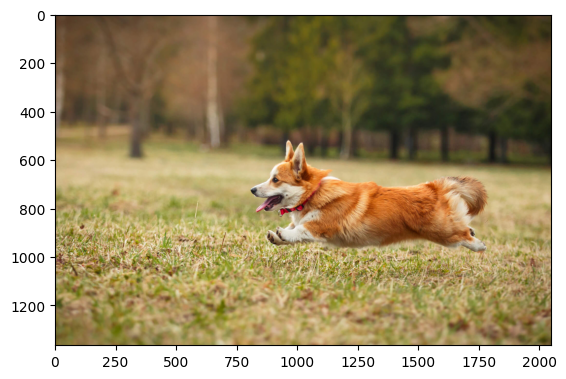

In [8]:
plt.imshow(img.permute(1,2,0)/255)

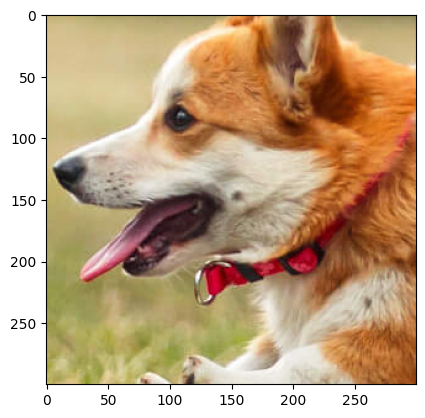

In [8]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
plt.imshow(crop.permute(1,2,0)/255)

In [9]:


def extract_patch(image_tensor, patch_location, patch_size):
    """Extract a rectangular patch from the image tensor."""
    # Define patch coordinates
    patch_x, patch_y = patch_location

    # Extract the patch into a different variable
    extracted_patch = image_tensor[:,patch_x:patch_x+patch_size, patch_y:patch_y+patch_size].clone()

    return extracted_patch


def make_patch_nan(image_tensor, patch_location, patch_size):
    """Make a rectangular patch of an image as NaN values."""
    # Copy the image tensor to avoid modifying the original
    image_tensor = image_tensor.clone()

    # Define patch coordinates
    patch_x, patch_y = patch_location

    # Set the patch region to NaN values
    image_tensor[:,patch_x:patch_x+patch_size, patch_y:patch_y+patch_size] = float('nan')

    return image_tensor

# Example usage
# Assuming you have 'image_tensor', 'patch_location', and 'patch_size' defined




In [88]:
patch_loc=(50,260)
patch_size=30

In [89]:
# Make the patch region NaN values
image_tensor_with_nan_patch = make_patch_nan(crop, patch_loc, patch_size)

In [90]:

extracted_patch = extract_patch(crop, patch_loc, patch_size)
extracted_patch.shape

torch.Size([3, 30, 30])

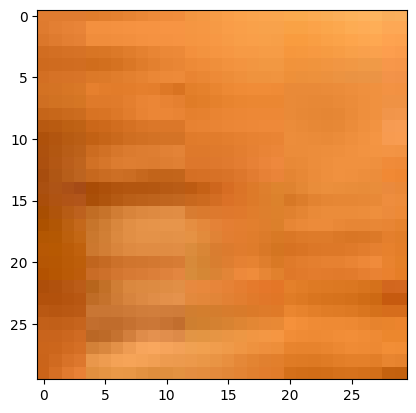

In [91]:

plt.imshow(extracted_patch.permute(1, 2, 0)/255)

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


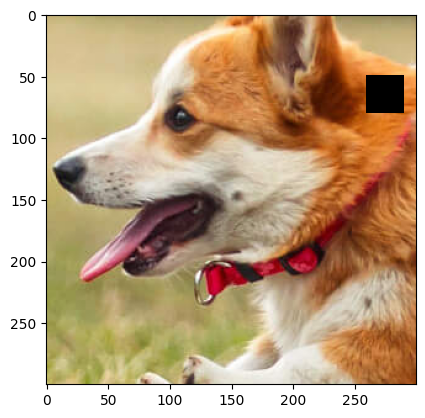

In [15]:
plt.imshow(image_tensor_with_nan_patch.permute(1,2,0)/255)

In [56]:
rank=500

In [92]:
weights, losses = factorize_color(image_tensor_with_nan_patch, rank, device)

tensor(55940.6094, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(55386.2383, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(54329.6797, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51753.0938, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(45200.8477, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(29279.1582, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(11936.9395, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(11096.1172, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10428.5557, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(9648.5801, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(8739.1016, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(7736.6602, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(6741.4771, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5854.9453, device='cuda:0', grad_fn=<LinalgVecto

In [93]:
weights_2, losses_2 = factorize_color_2(image_tensor_with_nan_patch, 500, device)

tensor(138519.5781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24508.1602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4260.3247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(341.0255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(396.2329, device='cuda:0', grad_fn=<AddBackward0>)
tensor(318.6967, device='cuda:0', grad_fn=<AddBackward0>)
tensor(293.1335, device='cuda:0', grad_fn=<AddBackward0>)
tensor(283.2812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(264.8540, device='cuda:0', grad_fn=<AddBackward0>)
tensor(191.4757, device='cuda:0', grad_fn=<AddBackward0>)
tensor(176.1162, device='cuda:0', grad_fn=<AddBackward0>)
tensor(200.1694, device='cuda:0', grad_fn=<AddBackward0>)
tensor(134.8470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(166.1805, device='cuda:0', grad_fn=<AddBackward0>)
tensor(224.4384, device='cuda:0', grad_fn=<AddBackward0>)


In [94]:
WR,HR,WG,HG,WB,HB=weights_2
pred_imgR=torch.mm(WR, HR).cpu().detach()
pred_imgG=torch.mm(WG, HG).cpu().detach()
pred_imgB=torch.mm(WB, HB).cpu().detach()
image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
pred_image_2 = torch.tensor(image)

In [95]:
WR,HR,WG,HG,WB,HB=weights
pred_imgR=torch.mm(WR, HR).cpu().detach()
pred_imgG=torch.mm(WG, HG).cpu().detach()
pred_imgB=torch.mm(WB, HB).cpu().detach()
image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
pred_image = torch.tensor(image)

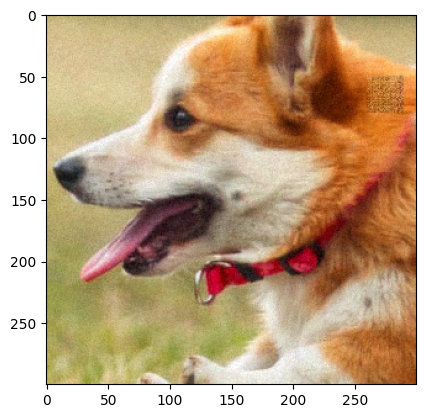

In [96]:
plt.imshow(pred_image.permute(1,2,0)/255)

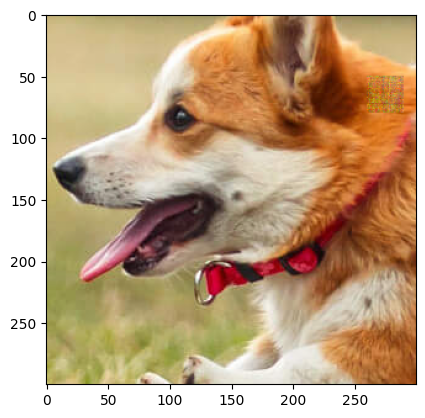

In [97]:
plt.imshow(pred_image_2.permute(1,2,0)/255)

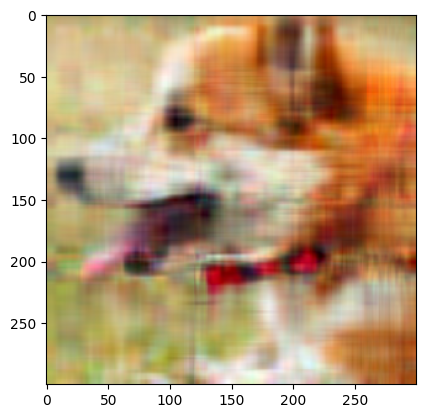

In [39]:
plt.imshow(pred_image.permute(1,2,0)/255)

In [98]:
PSNR = peak_signal_noise_ratio((crop/255).numpy(), (pred_image/255).numpy())
PSNR_2 = peak_signal_noise_ratio((crop/255).numpy(), (pred_image_2/255).numpy())
PSNR,PSNR_2

(30.185585220994355, 38.79101168267138)

In [100]:
rmse = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_image/255).numpy()))
rmse_2 = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_image_2/255).numpy()))
rmse,rmse_2

(0.030954282296610954, 0.011493423668080604)

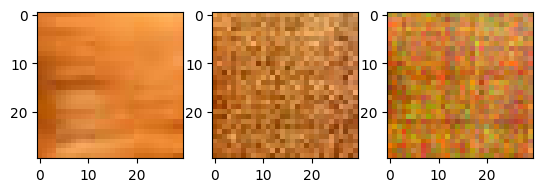

In [99]:
extracted_patch_pred = extract_patch(pred_image, patch_loc, patch_size)
extracted_patch_pred_2 = extract_patch(pred_image_2, patch_loc, patch_size)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(extracted_patch.permute(1, 2, 0)/255)
plt.subplot(1,3,2)
plt.imshow(extracted_patch_pred.permute(1, 2, 0)/255)
plt.subplot(1,3,3)
plt.imshow(extracted_patch_pred_2.permute(1, 2, 0)/255)


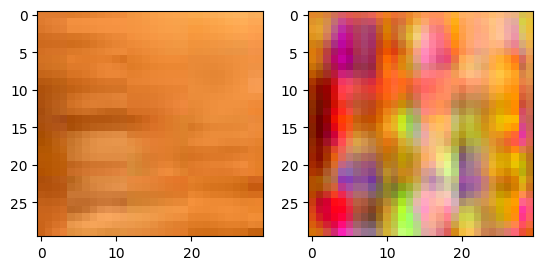

In [47]:
extracted_patch_pred = extract_patch(pred_image, patch_loc, patch_size)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(extracted_patch.permute(1, 2, 0)/255)
plt.subplot(1,2,2)
plt.imshow(extracted_patch_pred.permute(1, 2, 0)/255)


In [70]:

import random

def add_n_random_nans(image, n):
    # Convert image to tensor if it's not already
    if not torch.is_tensor(image):
        image = torch.tensor(image)

    # Get image dimensions
    num_channels, height, width = image.shape

    # Flatten image tensor
    flat_image = image.reshape(num_channels, -1)

    # Generate random indices for n pixels
    indices = random.sample(range(height * width), n)

    # Set values at selected indices to NaN for each channel
    for channel in range(num_channels):
        flat_image[channel][indices] = float('nan')

    # Reshape the flattened tensor to original shape
    image_with_nans = flat_image.reshape(num_channels, height, width)

    return image_with_nans

image_with_nans = add_n_random_nans(crop, 900)



/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


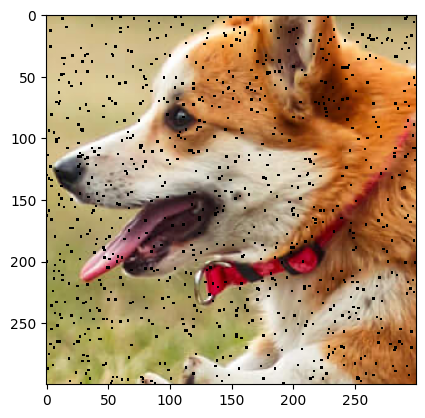

In [71]:
plt.imshow(image_with_nans.permute(1,2,0)/255)

tensor(138423.8750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24536.0547, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4288.2949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(366.4187, device='cuda:0', grad_fn=<AddBackward0>)
tensor(284.9987, device='cuda:0', grad_fn=<AddBackward0>)
tensor(236.2195, device='cuda:0', grad_fn=<AddBackward0>)
tensor(197.0940, device='cuda:0', grad_fn=<AddBackward0>)
tensor(171.5963, device='cuda:0', grad_fn=<AddBackward0>)
tensor(145.3069, device='cuda:0', grad_fn=<AddBackward0>)
tensor(169.9710, device='cuda:0', grad_fn=<AddBackward0>)
tensor(201.3651, device='cuda:0', grad_fn=<AddBackward0>)
tensor(170.6364, device='cuda:0', grad_fn=<AddBackward0>)
tensor(135.1116, device='cuda:0', grad_fn=<AddBackward0>)
tensor(213.1671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(275.7541, device='cuda:0', grad_fn=<AddBackward0>)
tensor(169.0362, device='cuda:0', grad_fn=<AddBackward0>)
tensor(281.2935, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1

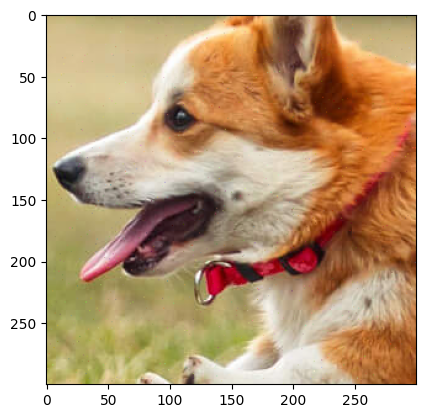

In [104]:
weights, losses = factorize_color_2(image_with_nans, 500, device)
WR,HR,WG,HG,WB,HB=weights
pred_imgR=torch.mm(WR, HR).cpu().detach()
pred_imgG=torch.mm(WG, HG).cpu().detach()
pred_imgB=torch.mm(WB, HB).cpu().detach()
image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
pred_image_2 = torch.tensor(image)
plt.imshow(pred_image_2.permute(1,2,0)/255)


41.9375447012675

tensor(56062.1680, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(55506.0508, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(54446.8203, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(51863.6602, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(45291.8750, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(29296.5332, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(11894.0186, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(11082.8604, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(10417.3525, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(9638.7383, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(8731.2217, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(7732.9321, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(6745.0825, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5866.2954, device='cuda:0', grad_fn=<LinalgVecto

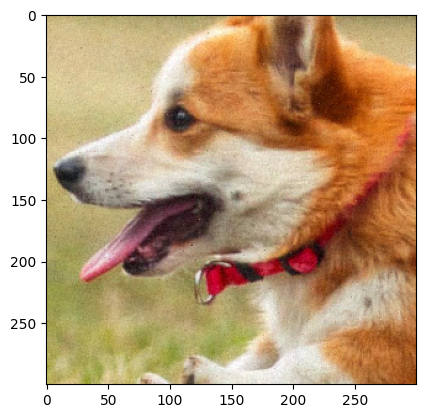

In [102]:
weights, losses = factorize_color(image_with_nans, 500, device)
WR,HR,WG,HG,WB,HB=weights
pred_imgR=torch.mm(WR, HR).cpu().detach()
pred_imgG=torch.mm(WG, HG).cpu().detach()
pred_imgB=torch.mm(WB, HB).cpu().detach()
image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
pred_image = torch.tensor(image)
plt.imshow(pred_image.permute(1,2,0)/255)


In [80]:
PSNR = peak_signal_noise_ratio((crop/255).numpy(), (pred_image/255).numpy())
PSNR_2 = peak_signal_noise_ratio((crop/255).numpy(), (pred_image_2/255).numpy())
PSNR,PSNR_2

(30.3583450584107, 42.20405450323096)

In [103]:
rmse = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_image/255).numpy()))
rmse_2 = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_image_2/255).numpy()))
rmse,rmse_2

(0.030344692932033075, 0.007758848552920304)

In [13]:
import numpy as np

In [14]:
patch_loc=(50,200)
patch_sizes = [20, 40, 60, 80]
patches=[]
inp_images_rect=[]
inp_images_rand=[]
pred_images_rect=[]
pred_images_rand=[]
for patch_size in patch_sizes:
  # Make the patch region NaN values
  n = patch_size * patch_size  # Number of random pixels to change to NaN
  image_with_nans = add_n_random_nans(crop, n)
  inp_images_rand.append(image_with_nans)
  image_tensor_with_nan_patch = make_patch_nan(crop, patch_loc, patch_size)
  inp_images_rect.append(image_tensor_with_nan_patch)
  patches.append(extract_patch(crop, patch_loc, patch_size))
  weights, losses = factorize_color(image_tensor_with_nan_patch, 75, device)
  WR,HR,WG,HG,WB,HB=weights
  pred_imgR=torch.mm(WR, HR).cpu().detach()
  pred_imgG=torch.mm(WG, HG).cpu().detach()
  pred_imgB=torch.mm(WB, HB).cpu().detach()
  image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
  pred_image = torch.tensor(image)
  pred_images_rect.append(pred_image)
  weights, losses = factorize_color(image_with_nans, 75, device)
  WR,HR,WG,HG,WB,HB=weights
  pred_imgR=torch.mm(WR, HR).cpu().detach()
  pred_imgG=torch.mm(WG, HG).cpu().detach()
  pred_imgB=torch.mm(WB, HB).cpu().detach()
  image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
  pred_image = torch.tensor(image)
  pred_images_rand.append(pred_image)


tensor(137704.6875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(50087.0078, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34720.6914, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25158.9297, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16190.5957, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10907.8008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7490.6021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5464.7866, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4181.0391, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3380.4558, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2915.6665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2656.0513, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2522.6655, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2457.1174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2424.6978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2407.2383, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2396.8630, device='cuda:0', grad_fn=<AddBa

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


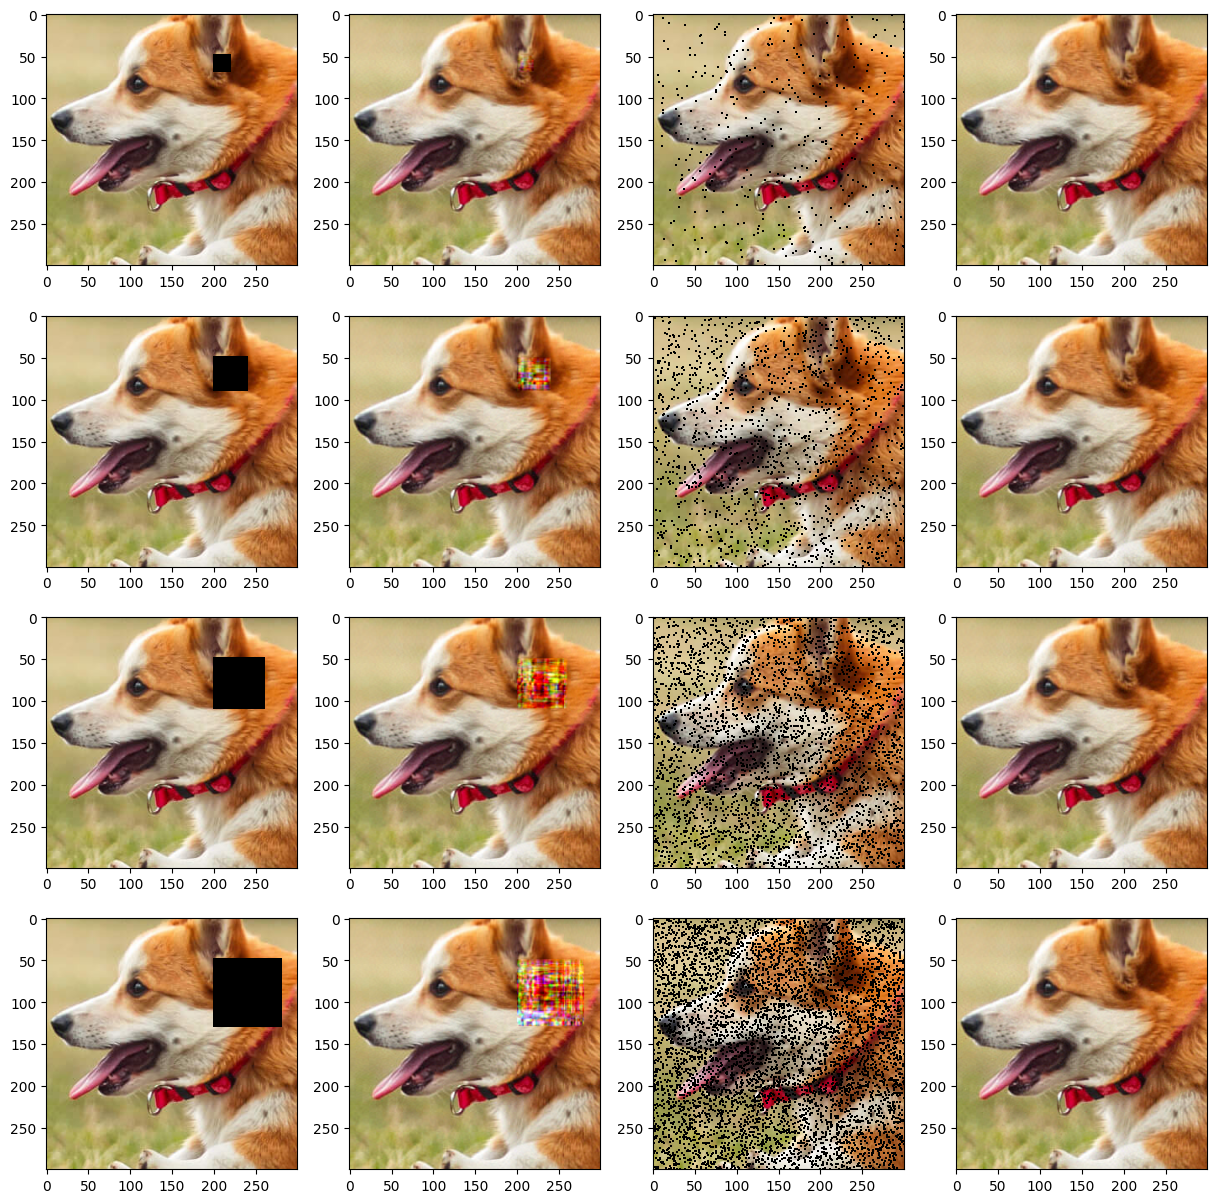

In [15]:
plt.figure(figsize=(15,15))
for i in range(len(patch_sizes)):
  plt.subplot(len(patch_sizes),4,i*4+1)
  plt.imshow(inp_images_rect[i].permute(1,2,0)/255)
  plt.subplot(len(patch_sizes),4,i*4+2)
  plt.imshow(pred_images_rect[i].permute(1,2,0)/255)
  plt.subplot(len(patch_sizes),4,i*4+3)
  plt.imshow(inp_images_rand[i].permute(1,2,0)/255)
  plt.subplot(len(patch_sizes),4,i*4+4)
  plt.imshow(pred_images_rand[i].permute(1,2,0)/255)


In [16]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

In [17]:
rmse_rect=[]
rmse_rand=[]
for i in range(4):
  rmse = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_images_rect[i]/255).numpy()))
  rmse_rect.append(rmse)
  print(f"RMSE of rectangular patch for Patch size {patch_sizes[i]} :", rmse,"\n")
  rmse = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_images_rand[i]/255).numpy()))
  rmse_rand.append(rmse)
  print(f"RMSE of randomly removed data for Patch size {patch_sizes[i]} :", rmse,"\n")


RMSE of rectangular patch for Patch size 20 : 0.014998411765013762 

RMSE of randomly removed data for Patch size 20 : 0.01057523490004132 

RMSE of rectangular patch for Patch size 40 : 0.038863880116002524 

RMSE of randomly removed data for Patch size 40 : 0.010695428887976557 

RMSE of rectangular patch for Patch size 60 : 0.06119359402638519 

RMSE of randomly removed data for Patch size 60 : 0.011002269026280556 

RMSE of rectangular patch for Patch size 80 : 0.08004756627665667 

RMSE of randomly removed data for Patch size 80 : 0.011443323030101281 



In [18]:
psnr_rect=[]
psnr_rand=[]
for i in range(4):
  PSNR = peak_signal_noise_ratio((crop/255).numpy(), (pred_images_rect[i]/255).numpy())
  psnr_rect.append(PSNR)
  print(f"PSNR of rectangular patch for Patch size {patch_sizes[i]} :", PSNR,"\n")
  PSNR = peak_signal_noise_ratio((crop/255).numpy(), (pred_images_rand[i]/255).numpy())
  psnr_rand.append(PSNR)
  print(f"PSNR of randomly removed data for Patch size {patch_sizes[i]} :", PSNR,"\n")

PSNR of rectangular patch for Patch size 20 : 36.479094549832844 

PSNR of randomly removed data for Patch size 20 : 39.51419954353361 

PSNR of rectangular patch for Patch size 40 : 28.209076844232413 

PSNR of randomly removed data for Patch size 40 : 39.41603590965285 

PSNR of rectangular patch for Patch size 60 : 24.26588078081631 

PSNR of randomly removed data for Patch size 60 : 39.170354798703634 

PSNR of rectangular patch for Patch size 80 : 21.933037352016886 

PSNR of randomly removed data for Patch size 80 : 38.82895684639472 



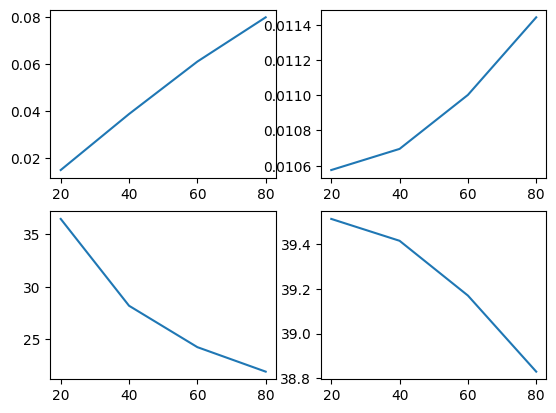

In [19]:
plt.subplot(2,2,1)
plt.plot(patch_sizes,rmse_rect)
plt.title()
plt.subplot(2,2,2)
plt.plot(patch_sizes,rmse_rand)
plt.subplot(2,2,3)
plt.plot(patch_sizes,psnr_rect)
plt.subplot(2,2,4)
plt.plot(patch_sizes,psnr_rand)


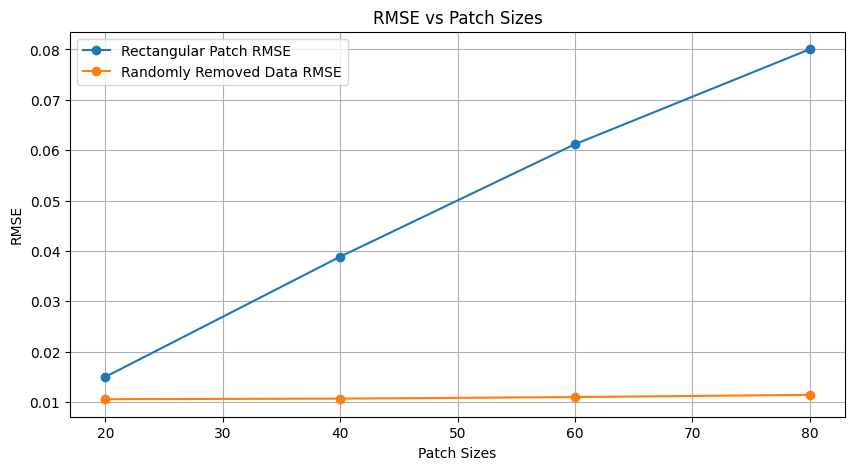

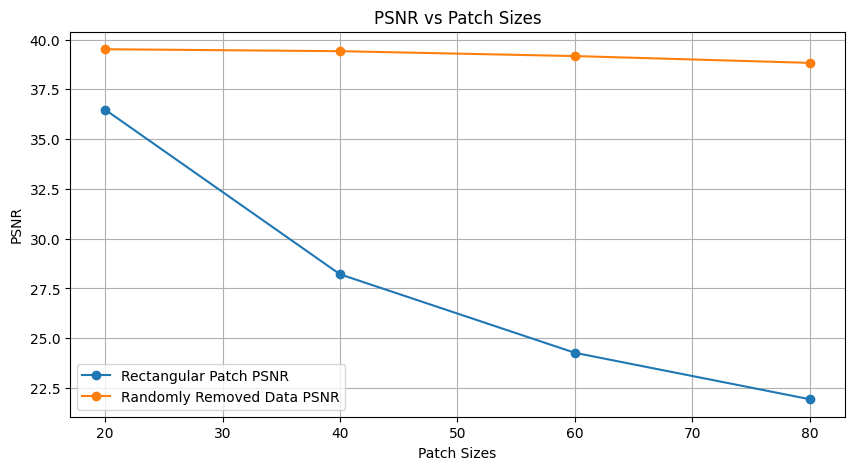

In [20]:
# Plotting RMSE vs Patch Sizes
plt.figure(figsize=(10, 5))
plt.plot(patch_sizes, rmse_rect, marker='o', label='Rectangular Patch RMSE')
plt.plot(patch_sizes, rmse_rand, marker='o', label='Randomly Removed Data RMSE')
plt.title('RMSE vs Patch Sizes')
plt.xlabel('Patch Sizes')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Plotting PSNR vs Patch Sizes
plt.figure(figsize=(10, 5))
plt.plot(patch_sizes, psnr_rect, marker='o', label='Rectangular Patch PSNR')
plt.plot(patch_sizes, psnr_rand, marker='o', label='Randomly Removed Data PSNR')
plt.title('PSNR vs Patch Sizes')
plt.xlabel('Patch Sizes')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.show()